In [151]:
import os
import pyabf
import numpy as np
import scipy as sp
from tqdm import tqdm

from scipy.signal import medfilt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import glob  
import seaborn as sns
import pandas as pd


In [235]:
colors = plt.cm.Dark2(np.linspace(0, 1, 6))


In [23]:
## def values
def_params = {'height':10,'distance':25}

#### utils
def extract_paired(data_path, n_sweeps=21):
    '''
    input: path string
    output: raw data (see dict)
    '''
    data_tmp = pyabf.ABF(data_path)
    sweep_data = []
    
    for sweep in range(n_sweeps):
        
        data_tmp.setSweep(sweepNumber=sweep, channel=0) 
        ch1 = data_tmp.sweepY

        times = data_tmp.sweepX

        # muscle
        data_tmp.setSweep(sweepNumber=sweep, channel=1) 
        ch2 = data_tmp.sweepY
        
        sweep_data.append([times, ch1, ch2])


    return {
            'data':sweep_data,
            'misc':data_tmp,
           }

def filter_data(data_array, kernel_size=1501):
    '''
    
    performs median filtering (low pass filtering) 
    
    input: data array (np array 1d), kernel size (int)
    output: data array (np array 1d, same shape at input), correction (np array 1d, same shape at input)
    '''
    correction = medfilt(data_array, kernel_size=kernel_size)
    filtered_data = data_array - correction + np.median(data_array)
    
    return filtered_data, correction

        
def peak_finding(data_array, active_window, params=def_params):
    '''
    input: data array (np array 1d), 
        active_window [2,1] start and end of the window
        params
    
    '''
    
    peaks_ids,_ = find_peaks(data_array, 
                         height=params['height'], 
                         distance=params['distance'])
    
    
    non_edge_peaks = peaks_ids[np.bitwise_and(peaks_ids>active_window[0], peaks_ids<active_window[1])]
    peak_heights = data_array[non_edge_peaks]

    return non_edge_peaks, peak_heights

In [24]:
n_sweeps = 21
f_name = '../../data/4_Aplysia/wednesday/21o13000.abf'
data = extract_paired(f_name, n_sweeps=n_sweeps)


In [130]:
all_stim_peaks = []
all_peaks = []
all_filt = []

for i in tqdm(range(n_sweeps)):
    # plot
#     plt.plot(data['data'][i][0], data['data'][i][1])
#     plt.plot(data['data'][i][0], data['data'][i][2])
#     plt.show()

    #filter
    filt_data = filter_data(data['data'][i][2])
    # get peaks
    stim_non_edge_peaks, _ = peak_finding(filt_data[0], 
                                                [0,100000], 
                                                params={'height':np.mean(filt_data[0]),'distance':1000})
    
    all_stim_peaks.append(stim_non_edge_peaks)
    all_filt.append(filt_data[0])
    

    

100%|██████████| 21/21 [02:02<00:00,  5.85s/it]


In [128]:
# for i in range(n_sweeps):

#     plt.plot( data['data'][i][0], all_filt[i])
#     plt.scatter( data['data'][i][0][all_stim_peaks[i]], all_filt[i][all_stim_peaks[i]])
#     plt.xlim(1,5)
#     plt.show()


In [146]:
#valid_id =  np.where([len(i)>4 for i in all_peaks])[0]
firing_rate_stim = [np.where((i>10000) & (i<60000))[0].size/5 for i in all_stim_peaks]
firing_rate_post = [np.where((i>60000))[0].size/4 for i in all_stim_peaks]
firing_rate_pre = [np.where((i>10000))[0].size/1 for i in all_stim_peaks]

In [212]:
def func(x, a,m,c):
    return np.maximum(m*x+c, a)

x = np.linspace(-1.5,1.5,21)

params_stim, _ = curve_fit(func, x, firing_rate_stim)

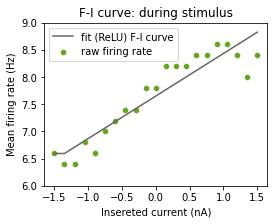

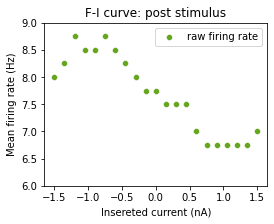

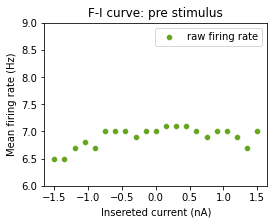

In [285]:
##### plt.style.use('seaborn-deep')
plt.figure(figsize=(4, 3))

plt.title('F-I curve: during stimulus')
sns.scatterplot(x=x, y=np.array(firing_rate_stim), label='raw firing rate', color=colors[3])
sns.lineplot(x=x, y=func(x, *params_stim), label='fit (ReLU) F-I curve', color=colors[5])
plt.xlabel('Insereted current (nA)')
plt.ylabel('Mean firing rate (Hz)')
plt.xlim
plt.ylim(6, 9)

plt.show()

plt.figure(figsize=(4, 3))

plt.title('F-I curve: post stimulus')
sns.scatterplot(x=x, y=np.array(firing_rate_post), label='raw firing rate', color=colors[3])
plt.xlabel('Insereted current (nA)')
plt.ylabel('Mean firing rate (Hz)')
plt.xlim
plt.ylim(6, 9)

plt.show()

plt.figure(figsize=(4, 3))

plt.title('F-I curve: pre stimulus')
sns.scatterplot(x=x, y=np.array(firing_rate_pre)/10, label='raw firing rate', color=colors[3])
plt.xlabel('Insereted current (nA)')
plt.ylabel('Mean firing rate (Hz)')
plt.xlim
plt.ylim(6, 9)

plt.show()

In [298]:
from sklearn.metrics import r2_score, explained_variance_score

r2_score(firing_rate_stim, func(x, *params_stim))

0.8671001185036022

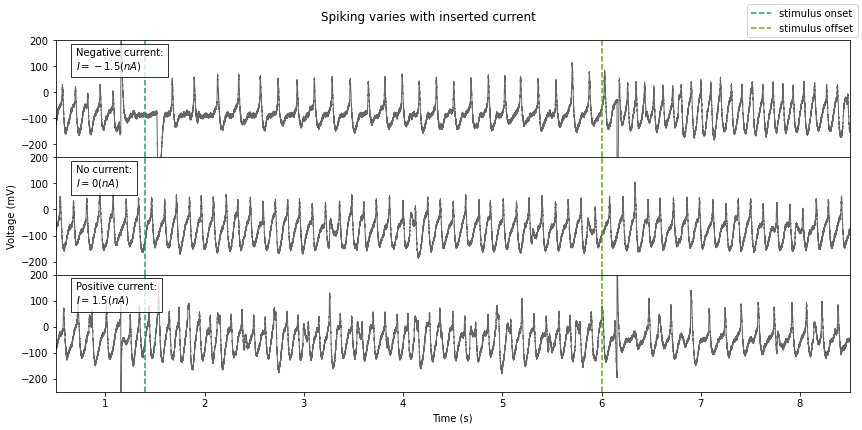

In [293]:
plt.style.use('seaborn-deep')


fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(3, hspace=0)
axes = gs.subplots(sharex=True, sharey=True)

plt.suptitle('Spiking varies with inserted current')

#axes[0].set_title(r'Negative inserted current: $I=-1.5 (A)$')
axes[0].set_xlabel('Time (s)')
#axes[0].set_ylabel('Membrane potential (mV)')

scale_y_ax0 = (all_filt[0]-19.5)*100-70
sns.lineplot(ax=axes[0], x=data['data'][0][0], y=scale_y_ax0,color=colors[5],linewidth = 1)
axes[0].axvline(1.4, linestyle='--' ,color=colors[0], label='stimulus onset')
axes[0].axvline(6, linestyle='--' ,color=colors[3], label='stimulus offset')
axes[0].text(.7, 90, 'Negative current:\n$I=-1.5 (nA)$',
             bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

#sns.scatterplot(ax=axes[0], x=data['data'][0][0][all_stim_peaks[0]], y=scale_y_ax0[all_stim_peaks[0]], label='stim peaks')


#axes[1].set_title(r'No inserted current: $I=0 (A)$')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Voltage (mV)')

scale_y_ax1 = (all_filt[10]+16.5)*100-70
sns.lineplot(ax=axes[1], x=data['data'][10][0], y=scale_y_ax1, color=colors[5],linewidth = 1)
axes[1].axvline(1.4, linestyle='--' ,color=colors[0])#, label='stim onset')
axes[1].axvline(6, linestyle='--' ,color=colors[3])#, label='stim offset')
axes[1].text(.7, 90, 'No current:\n$I=0 (nA)$',
             bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

#sns.scatterplot(ax=axes[1], x=data['data'][10][0][all_stim_peaks[10]], y=scale_y_ax1[all_stim_peaks[10]])


#axes[2].set_title(r'Positive inserted current: $I=1.5 (A)$')
axes[2].set_xlabel('Time (s)')
#axes[2].set_ylabel('Membrane potential (mV)')

scale_y_ax2 = (all_filt[-1]+53)*100-70
sns.lineplot(ax=axes[2], x=data['data'][-1][0], y=scale_y_ax2, color=colors[5], linewidth = 1)
axes[2].axvline(1.4, linestyle='--' ,color=colors[0])#, label='stim onset')
axes[2].axvline(6, linestyle='--' ,color=colors[3])#, label='stim offset')
axes[2].text(.7, 90, 'Positive current:\n$I=1.5 (nA)$',
              bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
#sns.scatterplot(ax=axes[2], x=data['data'][-1][0][all_stim_peaks[-1]], y=scale_y_ax2[all_stim_peaks[-1]])

lines_labels=[]

for ax in axes:
    ax.label_outer()
    lines_labels.append(ax.get_legend_handles_labels())
    ax.legend([],[], frameon=False)


plt.ylim(-250, 200)
plt.xlim(0.5, 8.5)
plt.tight_layout()

lines, labels = [sum(l, []) for l in zip(*lines_labels)]
# lines[0],lines[1] = lines[1],lines[0]
# labels[0],labels[1] = labels[1],labels[0]

fig.legend(lines, labels)
#plt.legend()
plt.show()